Load and Preprocess the Data

In [4]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Define the dataset path
data_path = '/content/drive/MyDrive/Dataset'

In [6]:
# List all image filenames
all_files = [os.path.join(data_path, img) for img in os.listdir(data_path) if img.endswith('.jpg')]

In [7]:
# Create labels based on filenames
all_labels = [1 if 'img_1_' in img else 0 for img in all_files]

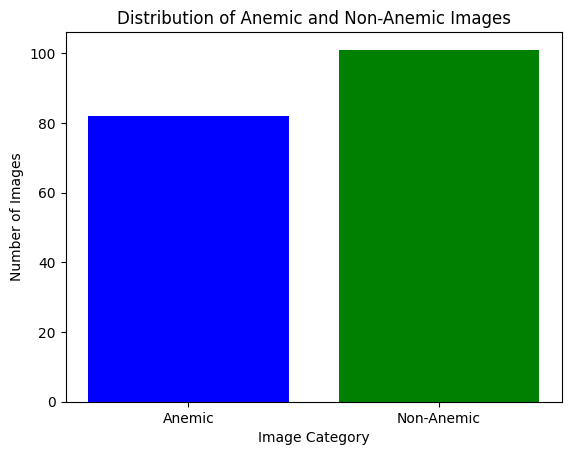

In [9]:
import matplotlib.pyplot as plt
anemic_count = all_labels.count(1)
non_anemic_count = all_labels.count(0)

# Create bar plot
labels = ['Anemic', 'Non-Anemic']
counts = [anemic_count, non_anemic_count]

plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Image Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Anemic and Non-Anemic Images')
plt.show()

In [ ]:
# Split dataset into training, validation, and test sets
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Convert file paths and labels to DataFrame
train_df = pd.DataFrame({'filename': train_files, 'label': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'label': val_labels})
test_df = pd.DataFrame({'filename': test_files, 'label': test_labels})

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [ ]:
# Data preprocessing for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)

Data Visualization

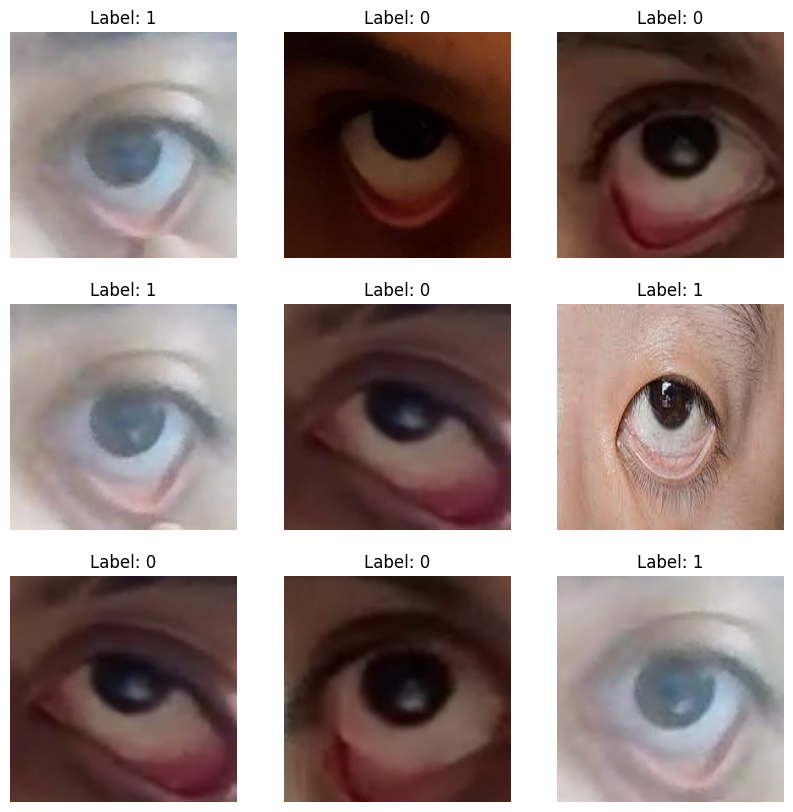

In [ ]:
import matplotlib.pyplot as plt

# Visualize sample images from the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(train_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Label: {train_labels[i]}")
    plt.axis("off")
plt.show()


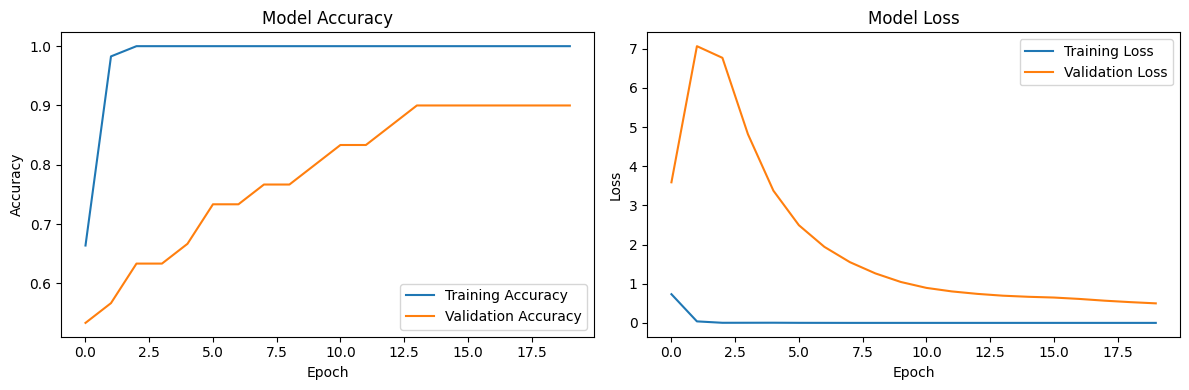

In [ ]:
# Training History Visualization
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


In [ ]:
# Function to apply Gaussian blur
def apply_gaussian_blur(images):
    blurred_images = []
    for img in images:
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        blurred_images.append(blurred)
    return np.array(blurred_images)

# Load and preprocess images
train_images = [cv2.imread(img_path) for img_path in train_files]
train_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_images]
train_images_blurred = apply_gaussian_blur(train_images)

# Convert images to numpy array
train_images_blurred = np.array(train_images_blurred)

# Flatten the blurred images
train_images_blurred_flattened = train_images_blurred.reshape(train_images_blurred.shape[0], -1)


In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(train_images_blurred_flattened, train_labels)

GaussianNB()

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(train_images_blurred_flattened, train_labels)

LogisticRegression(max_iter=10000)

In [ ]:
# MobileNetV2
from tensorflow.keras.applications import MobileNetV2

# Define MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create data generators
batch_size = 32
img_size = (224, 224)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_dataframe(val_df,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=img_size,
                                                batch_size=batch_size,
                                                class_mode='binary')

test_generator = val_datagen.flow_from_dataframe(test_df,
                                                 x_col='filename',
                                                 y_col='label',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode='binary')

Found 116 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.
Found 37 validated image filenames belonging to 2 classes.


In [ ]:
# Define CNN model architecture
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20
4/4 [==============================] - 57s 9s/step - loss: 0.7323 - accuracy: 0.6638 - val_loss: 3.5889 - val_accuracy: 0.5333
Epoch 2/20
4/4 [==============================] - 30s 6s/step - loss: 0.0385 - accuracy: 0.9828 - val_loss: 7.0645 - val_accuracy: 0.5667
Epoch 3/20
4/4 [==============================] - 26s 6s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 6.7669 - val_accuracy: 0.6333
Epoch 4/20
4/4 [==============================] - 25s 6s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.8188 - val_accuracy: 0.6333
Epoch 5/20
4/4 [==============================] - 25s 6s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 3.3752 - val_accuracy: 0.6667
Epoch 6/20
4/4 [==============================] - 24s 6s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.4937 - val_accuracy: 0.7333
Epoch 7/20
4/4 [==============================] - 26s 6s/step - loss: 7.0960e-04 - accuracy: 1.0000 - val_loss: 1.9410 - val_accuracy: 0.7333
Epoch 8/20
4/4 [==============

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

2/2 [==============================] - 2s 142ms/step - loss: 1.2625 - accuracy: 0.8649
Test accuracy: 86.49%


In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/model.h5')

In [ ]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 28802